In [17]:
import os
import keras
from keras.models import Sequential, load_model, model_from_json
from keras.layers import *
from tensorflow.python.client import timeline
from keras import metrics
import numpy as np
import matplotlib.pyplot as plt
# fix random seed for reproducibility
np.random.seed(0)
from overundersample import *
import pickle

In [2]:
with open("dataset_8s_us101-all.pkl", 'rb') as file:
    (X, columns) = pickle.load(file)

In [3]:
def matchList(listWhere, listStr):
    ret = []
    for i in range(len(listStr)):
        found = -1
        for j in range(len(listWhere)):
            if listWhere[j] == listStr[i]:
                found = j
                break
        ret.append(found)
    return ret

In [39]:
def extractXYData(data, columns):
    ftSelf = ['locX', 'locY', 'vx', 'vy']
    scale = {'x': 10, 'y': 10, 'vx': 1, 'vy': 10}
    ftOthers = ['locX', 'locY', 'vx', 'vy']
    listOthers = ['8','88','6','4','1','2','3','7','9']
    features = ftSelf + [i + '_s' + str(j) for i in ftOthers for j in listOthers]
    ftIdx = matchList(columns, features)
    outputFeatures = ['locX', 'locY', 'vx', 'vy']
    
    ySCols = matchList(columns, ['locY_s' + i for i in listOthers])
    xSCols = matchList(columns, ['locX_s' + i for i in listOthers])
    vySCols = matchList(columns, ['vy_s' + i for i in listOthers])
    vxSCols = matchList(columns, ['vx_s' + i for i in listOthers])
    yCol = matchList(columns, ['locY'])
    xCol = matchList(columns, ['locX'])
    vxCol = matchList(columns, ['vx'])
    vyCol = matchList(columns, ['vy'])
    
    n_post = 50
    rangenpost = [10,20,30,40,50]
    
    ncols = len(listOthers)
    X = np.zeros((1,data.shape[0]-n_post,5*ncols+4))
    Y = np.zeros((1,data.shape[0]-n_post,len(rangenpost)*len(outputFeatures)))
    colidx = 0
    for i in range(ncols):
        X[0,:,colidx] = data[0:-n_post, vxSCols[i]]/scale['vx']
        
        X[0,:,colidx+ncols] = (data[0:-n_post, vyCol[0]] - data[0:-n_post, vySCols[i]])/scale['vy']
        X[0,X[0,:,colidx+ncols] == 0,colidx+ncols] = 0.0001
        X[0,:,colidx+ncols] = np.sign(X[0,:,colidx+ncols])*np.maximum(0.01, np.abs(X[0,:,colidx+ncols]))
        
        X[0,:,colidx+2*ncols] = (data[0:-n_post, ySCols[i]] - data[0:-n_post, yCol[0]])/X[0,:,colidx+ncols]/scale['y']*scale['vy']
        X[0,X[0,:,colidx+2*ncols] > 10, colidx+2*ncols] = 10.0
        X[0,X[0,:,colidx+2*ncols] < -10, colidx+2*ncols] = -10.0
        X[0,:, colidx+2*ncols] /= 10.0
        X[0,:,colidx+3*ncols] = (data[0:-n_post, ySCols[i]] - data[0:-n_post, yCol[0]])/scale['y']
        X[0,:,colidx+4*ncols] = (data[0:-n_post, xSCols[i]] - data[0:-n_post, xCol[0]])/scale['x']
        colidx += 1
    X[0,:,5*ncols] = data[0:-n_post, xCol[0]]/scale['x']
    X[0,:,5*ncols+1] = data[0:-n_post, yCol[0]]/scale['y']
    X[0,:,5*ncols+2] = data[0:-n_post, vxCol[0]]/scale['vx']
    X[0,:,5*ncols+3] = data[0:-n_post, vyCol[0]]/scale['vy']
    k = 0
    nft = len(outputFeatures)
    for nn in rangenpost:
        Y[0,:,nft*k+0] = data[nn:data.shape[0]-(n_post-nn), xCol[0]]/scale['x']
        Y[0,:,nft*k+1] = data[nn:data.shape[0]-(n_post-nn), yCol[0]]/scale['y']
        Y[0,:,nft*k+2] = data[nn:data.shape[0]-(n_post-nn), vxCol[0]]/scale['vx']
        Y[0,:,nft*k+3] = data[nn:data.shape[0]-(n_post-nn), vyCol[0]]/scale['vy']
        k += 1
    return X, Y

In [40]:
trainX, trainY = extractXYData(X[1], columns)

In [6]:
keys = list(X.keys())
nkeys = len(keys)
#nkeys = 100
sel = np.random.rand(nkeys)
pcvalid = 0.2
trainset = list(np.squeeze(np.where(sel < 1-pcvalid)))
testset = list(np.squeeze(np.where(sel >= 1-pcvalid)))

In [41]:
trainData = {}
testData = {}
for k in trainset:
    trainX, trainY = extractXYData(X[keys[k]], columns)
    trainData[k] = {'x': trainX, 'y': trainY}
for k in testset:
    testX, testY = extractXYData(X[keys[k]], columns)
    testData[k] = {'x': testX, 'y': testY}

In [37]:
lstm = Sequential()
lstm.add(LSTM(256,input_shape=(None,trainX.shape[2]-4), return_sequences=True))
#model.add(LSTM(100,return_sequences=True))
#model.add(LSTM(100,return_sequences=True))
lstm.add(TimeDistributed(Dense(256, activation='linear')))
lstm.add(TimeDistributed(Dense(64, activation='linear')))

bypass = Sequential()
bypass.add(InputLayer(input_shape=(None,4)))

model = Sequential()
model.add(Merge([lstm, bypass],mode='concat'))
# model.add(TimeDistributed(Dense(256, activation='linear')))
model.add(TimeDistributed(Dense(10, activation='linear')))
model.compile(optimizer='adam', loss='mse')

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [18]:
keras

<module 'keras' from 'C:\\Anaconda3\\lib\\site-packages\\keras\\__init__.py'>

In [ ]:
for epoch in range(20):
    print('Epoch', epoch)
    tot = len(trainset)
    n = 0
    shp = trainData[trainset[0]]
    carsPerBatch = 500
    for k in range(0,tot,carsPerBatch):
        numts = 100
        trainx = []
        trainy = []
        for kk in range(carsPerBatch):
            try:
                dat = trainData[trainset[k+kk]]
                daty = np.squeeze(dat['y'])[:,[0,4,8,12,16,3,7,11,15,19]] # remove unwanted columns
                listts = [i for i in range(0,dat['x'].shape[1]-numts,10)]
                for i in range(len(listts)):
                    ts = listts[i]
                    trainx += [dat['x'][0,ts:(ts+numts),:]]
                    trainy += [daty[ts:(ts+numts),:]]
            except IndexError:
                break
        
        trainx = np.array(trainx)
        trainy = np.array(trainy)
        print(trainx.shape,trainy.shape)
        model.fit([trainx, trainx[:,:,-4:]], trainy, epochs=5, verbose=1, shuffle=True)
        tmp = model.predict(dat['x'][[0],:,:])
        numts2 = tmp.shape[1]
        plt.plot(list(range(40,numts2+40)),tmp[0,:,4],'b')
        plt.plot(list(range(numts2)),dat['y'][0,:,0],color='g')
        plt.plot(list(range(40,numts2+40)),dat['y'][0,:,16],color='g')
        plt.show()
        plt.plot(list(range(40,numts2+40)),tmp[0,:,9],'b')
        plt.plot(list(range(numts2)),dat['y'][0,:,3],color='g')
        plt.plot(list(range(40,numts2+40)),dat['y'][0,:,19],color='g')
        plt.show()

Epoch 0
(31300, 100, 49) (31300, 100, 10)
Epoch 1/5
 2656/31300 [=>............................] - ETA: 135s - loss: 0.8633

In [109]:
model.save('lstm-12345-x-vy.h5')

In [112]:
rmse = [[] for i in range(10)]
for k in testData.keys():
    tmp = model.predict(testData[k]['x'][[0],:,:])
    tmp = np.squeeze(tmp)*10
    for i in range(5):
        ref = testData[k]['y'][0,:,4*i]*10
        rmse[i].append(np.sqrt(((tmp[:,i] - ref)**2).mean()))
    for i in range(5):
        ref = testData[k]['y'][0,:,3+4*i]*10
        rmse[5+i].append(np.sqrt(((tmp[:,5+i] - ref)**2).mean()))
rmse = np.array(rmse)
for i in range(5):
    print("pred x @", str(i+1)+'s', 'min', np.min(rmse[i,:]), 'max', np.max(rmse[i,:]), 'mean', np.mean(rmse[i,:]), 'std', np.std(rmse[i,:]))
    print("pred vy @", str(i+1)+'s', 'min', np.min(rmse[5+i,:]), 'max', np.max(rmse[5+i,:]), 'mean', np.mean(rmse[5+i,:]), 'std', np.std(rmse[5+i,:]))

pred x @ 1s min 0.0734984858541 max 0.938678406648 mean 0.178944601088 std 0.0999972179272
pred vy @ 1s min 0.390608133978 max 2.4487970874 mean 0.700095960213 std 0.220245405811
pred x @ 2s min 0.112829625381 max 1.24445383929 mean 0.25952135153 std 0.135311649633
pred vy @ 2s min 0.511927504752 max 3.23453374376 mean 0.932921602982 std 0.295646152906
pred x @ 3s min 0.129389144303 max 1.50890481324 mean 0.333206035731 std 0.193024935391
pred vy @ 3s min 0.579871994622 max 3.96903134229 mean 1.18291159586 std 0.394582990652
pred x @ 4s min 0.140759871866 max 1.69025766848 mean 0.398752128619 std 0.253469811958
pred vy @ 4s min 0.713023346971 max 4.73752535244 mean 1.46123119683 std 0.482903796434
pred x @ 5s min 0.15918294837 max 2.12266772145 mean 0.456669707297 std 0.31034510609
pred vy @ 5s min 0.854983700761 max 5.4837235625 mean 1.76849750941 std 0.568643736969


In [111]:
print("1s pred",np.min(rmse1s), np.max(rmse1s), np.mean(rmse1s), np.std(rmse1s))
print("2s pred",np.min(rmse2s), np.max(rmse2s), np.mean(rmse2s), np.std(rmse2s))
print("3s pred",np.min(rmse3s), np.max(rmse3s), np.mean(rmse3s), np.std(rmse3s))
print("5s pred",np.min(rmse5s), np.max(rmse5s), np.mean(rmse5s), np.std(rmse5s))

NameError: name 'rmse1s' is not defined

In [116]:
with open('testsetus101.pkl', 'wb') as file:
    pickle.dump(testset, file)

In [ ]:
rmse5s = rmse

In [ ]:
k = 274
plt.plot(testData[testset[k]]['x'][0,:,45])
plt.plot(testData[testset[k]]['y'][0,:,0])
plt.plot(testData[testset[k]]['y'][0,:,4])
plt.plot(testData[testset[k]]['y'][0,:,8])
plt.plot(testData[testset[k]]['y'][0,:,12])
plt.plot(testData[testset[k]]['y'][0,:,16])
plt.show()

In [ ]:
plt.plot(X[keys[1327]][:,2])
plt.show()

In [ ]:
keys[1321]

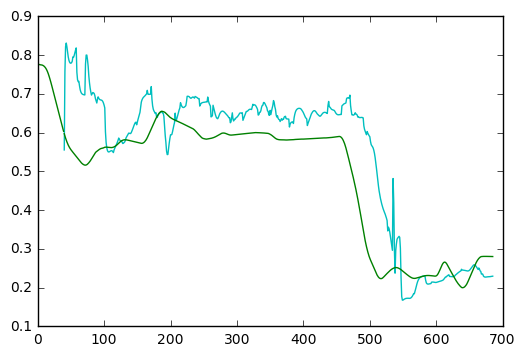

In [51]:
numts2 = tmp.shape[1]
#plt.plot(list(range(numts2)),tmp[0,:,0],'b')
#plt.plot(list(range(10,numts2+10)),tmp[0,:,1],'r')
#plt.plot(list(range(20,numts2+20)),tmp[0,:,2],'y')
#plt.plot(list(range(30,numts2+30)),tmp[0,:,3],'m')
plt.plot(list(range(40,numts2+40)),tmp[0,:,0],'c')
plt.plot(list(range(40)),dat['y'][0,:40,0],color='g')
plt.plot(list(range(40,numts2+40)),dat['y'][0,:,16],color='g')
plt.show()

array([[ 0.59743571],
       [ 0.59155584],
       [ 0.58602233],
       [ 0.58091278],
       [ 0.57621332],
       [ 0.57192118],
       [ 0.56803359],
       [ 0.5645561 ],
       [ 0.56148039],
       [ 0.55872611],
       [ 0.55621289],
       [ 0.55386871],
       [ 0.55166306],
       [ 0.54951284],
       [ 0.54734876],
       [ 0.54518468],
       [ 0.54301783],
       [ 0.54085375],
       [ 0.53868689],
       [ 0.53652004],
       [ 0.53435596],
       [ 0.53219188],
       [ 0.5300278 ],
       [ 0.52786095],
       [ 0.52569687],
       [ 0.52359098],
       [ 0.52173724],
       [ 0.52014397],
       [ 0.51880562],
       [ 0.5176834 ],
       [ 0.51684382],
       [ 0.51635891],
       [ 0.51628687],
       [ 0.51666925],
       [ 0.51751992],
       [ 0.51882502],
       [ 0.52052636],
       [ 0.5224272 ],
       [ 0.52452478],
       [ 0.52682186],
       [ 0.52935724],
       [ 0.53206442],
       [ 0.53486858],
       [ 0.53771708],
       [ 0.54056557],
       [ 0

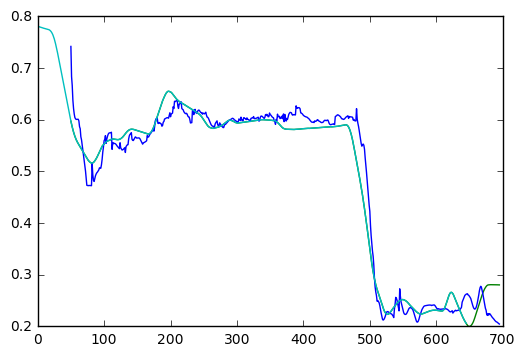

In [67]:
plt.plot(list(range(50,50+tmp.shape[1])),dat['y'][0,:,16],'g')
plt.plot(list(range(50,50+tmp.shape[1])),tmp[0,:,0],'b')
plt.plot(dat['x'][0,:,45],'c')
plt.show()

In [65]:
np.sqrt(((dat['y'][0,:,16]-tmp[0,:,0])**2).mean())

0.064264672144855012